# Value at Risk Assessment (VaR) with Monte-Carlo Simulation Model

### Import Packages

In [354]:
"Felipe Jaramillo Penagos"
"Modeling Risk with Monte Carlo Simulaiton"
"Value at Risk (VaR) Assessment"

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

In [355]:
# Summary:
# On the stock price prediction model (in another file) the output of each simulation was a price, 
# this time we also simulated a stock price evolution but the output of each simulation was a calculation 
# of profit or loss after one trading month.

# Distributions: We used key parameters: a) Current Investment Value, b) Risk Free Rate, c) Volatility from available data.
# Simulations: We used the VaR formula to calculate the return of holding investment for 1 month with 10,000 simulations
# Quantifications: We identified the one-month VaR at 90%, 95%, and 99% confidence.

### Distributions - Set Up Stock Parameters

In [356]:
# SETUP: Inputs and Parameters

ticker = 'MSFT'
n_shares = 1000
risk_rt = 0.0528                        # Risk-free rate (annualized) using 4-week treasury bill rate
r_monthly = 0.0528 / 12 
t_investment = 21                       # Convert to fraction of trading year
n_simulations = 10000                   # 10,000 simulations for Monte-Carlo process

# FETCH LIVE STOCK DATA
price_data = yf.Ticker(ticker)
current_price_msft = price_data.history().tail(1)['Close'][0]
print(f"MSFT Last Close: ${current_price_msft:.2f}")



MSFT Last Close: $389.97


30-day historical volatility source: https://www.alphaquery.com/stock/MSFT/volatility-option-statistics/30-day/historical-volatility

In [357]:
# VOLATILITY ESTIMATE (now computed dynamically based on 30-day period)

# Volatility (30-day volatility at that time)                 # On-practice, should be a dynamic moving volatility
# vol_msft = 0.2745                                           # also can be found online, sites such as AlphaQuery
hist_data = price_data.history(period='2mo')['Close']
log_returns = np.log(hist_data / hist_data.shift(1)).dropna() # changed vol to be dynamic and live w/ recent data
vol_daily = log_returns[-30:].std() 
vol_monthly = vol_daily * np.sqrt(t_investment)               # Monthly volatility (21 trading days ≈ 1 month)


# INVESTMENT DETAILS
investment_value = current_price_msft * n_shares
investment_value # this will change depending on the day we run code (updated on live data)

print(f"current value of investment is ${value_msft:,.2f}, current MSFT volatility is sigma = {vol_msft:,.2f}")


current value of investment is $389,970.00, current MSFT volatility is sigma = 0.22


### Simulations - Calculate Investment Returns

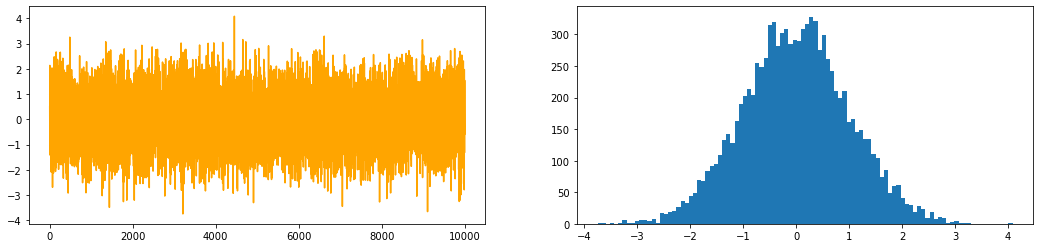

In [358]:
# Explain np.random.standard_normal
normal_dist = norm.rvs(loc=0, scale=1, size=n_simulations) # generate standard random variable sample(s)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

ax1.plot(normal_dist, color='orange')
ax2.hist(normal_dist, bins=100)  # the mean is 0 and std dev is 1. We'll use it to create 10000 samples.
plt.show()              

#### MONTE CARLO SIMULATION STEP

In [359]:
# Monte-Carlo Simlution 

# Step 1: Generate standard normal random shocks
# normal_dist generated in previous cell

# Step 2: Simulate future value using GBM closed-form
# GBM formula: S_t = S_0 * exp[(r - 0.5 * sigma^2)t + sigma * Z * sqrt(t)]  (written below for reference)
def simulate_returns(investment_value, r, vol, t, sims):
    Z = np.random.standard_normal(sims)
    end_value_sim = investment_value * np.exp((r - 0.5 * vol**2) * t + vol * Z * np.sqrt(t))
    pl = end_value_sim - investment_value
    return pl

t_months = 1
pl = simulate_returns(investment_value, r_monthly, vol_monthly, t_months, n_simulations)


$$
S_t = S_0 \cdot \exp\left[(r - \frac{1}{2}\sigma^2)t + \sigma Z \right]
$$

$$
S_{\text{1 month}} = S_0 \cdot \exp\left[(r_{\text{monthly}} - \frac{1}{2}\sigma_{\text{monthly}}^2) + \sigma_{\text{monthly}} Z \right]
$$

Where:

- \( S_0 \): Current investment value  
- \( r_{\text{monthly}} \): Monthly risk-free rate (e.g., 4-week T-bill)  
- \( \sigma_{\text{monthly}} \): Monthly volatility (from daily log returns × √21)  
- \( Z \sim \mathcal{N}(0, 1) \): Standard normal shock


In [360]:
print('Simulated returns descriptive statistics:') 
print(pd.DataFrame(pl).describe())
print(pd.DataFrame(pl).head())
print('check correct shape (21 days simulated 10,000 times):', 'array shape is', simulated_values.shape)

Simulated returns descriptive statistics:
                   0
count   10000.000000
mean     1810.787701
std     25277.736438
min    -89233.303136
25%    -15769.835197
50%       705.246193
75%     18717.112301
max    109050.225776
              0
0 -19952.244701
1  12787.551335
2  36886.242588
3  -2110.876791
4  -3250.357197
check correct shape (21 days simulated 10,000 times): array shape is (21, 10000)


#### Calculate Value at Risk (VaR) and Provide Quantifications

In [361]:
# Calculate Value at Risk (VaR)

confidence_levels = [0.95, 0.99]

for cl in confidence_levels:
    cutoff = np.percentile(pl, (1 - cl) * 100)
    var = -cutoff
    print(f"{int(cl*100)}% 1-Month VaR: ${var:,.2f}")


95% 1-Month VaR: $37,987.53
99% 1-Month VaR: $53,058.62


### Quantifications - Identify VaR at 90%, 95%, and 99% Confidence Level

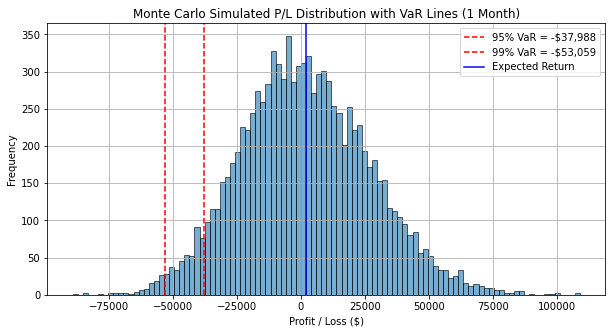

In [362]:
# ADDITIONAL METRICS
mean_return = np.mean(pl)
std_dev = np.std(pl)

# Histogram with VaR Overlay

plt.figure(figsize=(10, 5))
plt.hist(pl, bins=100, edgecolor='black', alpha=0.6)

for cl in confidence_levels:
    var = -np.percentile(pl, (1 - cl) * 100)
    plt.axvline(-var, color='red', linestyle='--', label=f"{int(cl*100)}% VaR = -${var:,.0f}")

plt.axvline(mean_return, color='blue', linestyle='-', label='Expected Return')
plt.title('Monte Carlo Simulated P/L Distribution with VaR Lines (1 Month)')
plt.xlabel('Profit / Loss ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


### Recap VaR Assessment Model

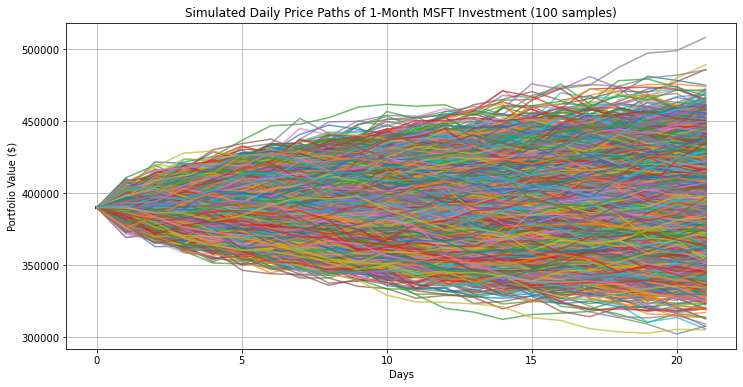

In [363]:
# Monte-Carlo Visualized:
# Full Price Path Simulation (Daily Steps)

n_steps = 21               # 21 trading days in a month
dt = 1 / 252               # daily time step
Z = np.random.standard_normal((n_steps, n_simulations))

# Start at current value
price_paths = np.zeros((n_steps + 1, n_simulations))
price_paths[0] = investment_value

# I used annualized vol/rate here for step-by-step GBM
r_annual = r_monthly * np.sqrt(12)
vol_annual = vol_monthly * np.sqrt(12)

for t in range(1, n_steps + 1):
    price_paths[t] = price_paths[t - 1] * np.exp((r_annual - 0.5 * vol_annual**2) * dt + vol_annual * Z[t - 1] * np.sqrt(dt))

# Plot Monte-Carlo Visual

plt.figure(figsize=(12,6))
plt.plot(price_paths, alpha=0.7)  # first 100 paths
plt.title('Simulated Daily Price Paths of 1-Month MSFT Investment (100 samples)')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()


In [364]:
# To recap results for monte carlo: 
final_vals = pd.DataFrame(price_paths).tail(1) # (final investment_value end of 21 days for each simulation)
final_vals = final_vals.T                      # transpose for descriptive stats

final_vals.describe()

,21
count,10000.000000
mean,390138.729429
std,24982.172022
min,305072.238336
25%,372633.610413
50%,389619.958253
75%,407115.782293
max,508106.180342
